In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter

import cell_order_log_analysis

import sys
sys.path.append('../radio_api')
import mcs_mapper
import constants

In [2]:
FIG_SIZE = (5,4.5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

RESERVATION = 'RES131702'
SCENARIO = 1024
reservation_data_dir = '../data/' + RESERVATION + '/'
target_rates = ['2M', '4M', '6M']

cell_order_log_filenames = {}
cell_order_ue_log_filenames = {}
for target_rate in target_rates:
    cell_order_log_filenames[target_rate] = \
        reservation_data_dir + 'cell-order-increasingRbg-lat-{}-{}.log'.format(SCENARIO, target_rate)
    cell_order_ue_log_filenames[target_rate] = \
        reservation_data_dir + 'cell-order-ue2-increasingRbg-lat-{}-{}.log'.format(SCENARIO, target_rate)

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period
N_PRB_PER_RBG = 3

In [3]:
def filter_bs_sla_stats(bs_data, budgets, ts_start):

    for user_id, supply_times in budgets['supply_times'].items():
        port_offset = int(user_id[0].split('.')[-1])
        sid = port_offset % constants.SLICE_NUM
        
        bs_data[sid]['filtered_ts_sec'] = []
        bs_data[sid]['filtered_lat_msec'] = []
        bs_data[sid]['filtered_thp_mbps'] = []
        for supply_time in supply_times:
            supply_time -= ts_start
            ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                       bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
            if (not ts_filter.any()):
                continue

            sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

            sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]
            lat_outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                                sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
            if (lat_outlier_filter.any()):
                bs_data[sid]['filtered_lat_msec'].append(np.mean(sla_lat_msec[lat_outlier_filter]))
            else:
                bs_data[sid]['filtered_lat_msec'].append(np.median(sla_lat_msec))

            sla_thp_mbps = bs_data[sid]['raw_tx_mbps'][ts_filter]
            thp_outlier_filter = np.logical_and(sla_thp_mbps <= np.percentile(sla_thp_mbps, 100 - OUTLIER_PERCENTILE),
                                                sla_thp_mbps >= np.percentile(sla_thp_mbps, OUTLIER_PERCENTILE))
            if (thp_outlier_filter.any()):
                bs_data[sid]['filtered_thp_mbps'].append(np.mean(sla_thp_mbps[thp_outlier_filter]))
            else:
                bs_data[sid]['filtered_thp_mbps'].append(np.median(sla_thp_mbps))

        bs_data[sid]['filtered_ts_sec'] = np.array(bs_data[sid]['filtered_ts_sec'])
        bs_data[sid]['filtered_lat_msec'] = np.array(bs_data[sid]['filtered_lat_msec'])
        bs_data[sid]['filtered_thp_mbps'] = np.array(bs_data[sid]['filtered_thp_mbps'])

In [4]:
def filter_ue_sla_stats(ue_data, sid):

    ue_data[sid]['filtered_ts_sec'] = []
    ue_data[sid]['filtered_rtt_msec'] = []
    ue_data[sid]['filtered_rtt_margin_msec'] = []
    ue_data[sid]['filtered_mbps'] = []
    ue_data[sid]['raw_n_rbgs'] = np.array([])
    cur_n_rbg = 1
    for supply_time in ue_data[sid]['supply_times']:
        ts_filter = np.logical_and(ue_data[sid]['raw_ts_sec'] >= supply_time,
                                   ue_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue

        sla_ts_sec = ue_data[sid]['raw_ts_sec'][ts_filter]
        ue_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

        sla_rtt_msec = ue_data[sid]['raw_rtt_msec'][ts_filter]
        rtt_upper_limit = np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE)
        rtt_lower_limit = np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE)
        lat_outlier_filter = np.logical_and(sla_rtt_msec <= rtt_upper_limit,
                                            sla_rtt_msec >= rtt_lower_limit)
        if (lat_outlier_filter.any()):
            rtt_mean = np.mean(sla_rtt_msec[lat_outlier_filter])
            ue_data[sid]['filtered_rtt_msec'].append(rtt_mean)
            ue_data[sid]['filtered_rtt_margin_msec'].append([rtt_mean - rtt_lower_limit, rtt_upper_limit - rtt_mean])
        else:
            ue_data[sid]['filtered_rtt_msec'].append(np.median(sla_rtt_msec))
            ue_data[sid]['filtered_rtt_margin_msec'].append([0, 0])

        sla_mbps = ue_data[sid]['raw_mbps'][ts_filter]
        thp_outlier_filter = np.logical_and(sla_mbps <= np.percentile(sla_mbps, 100 - OUTLIER_PERCENTILE),
                                            sla_mbps >= np.percentile(sla_mbps, OUTLIER_PERCENTILE))
        if (thp_outlier_filter.any()):
            ue_data[sid]['filtered_mbps'].append(np.mean(sla_mbps[thp_outlier_filter]))
        else:
            ue_data[sid]['filtered_mbps'].append(np.median(sla_mbps))

        ue_data[sid]['raw_n_rbgs'] = \
            np.concatenate((ue_data[sid]['raw_n_rbgs'], np.full(sla_ts_sec.shape, cur_n_rbg)))

        cur_n_rbg += 1

    ue_data[sid]['filtered_ts_sec'] = np.array(ue_data[sid]['filtered_ts_sec'])
    ue_data[sid]['filtered_rtt_msec'] = np.array(ue_data[sid]['filtered_rtt_msec'])
    ue_data[sid]['filtered_rtt_margin_msec'] = np.array(ue_data[sid]['filtered_rtt_margin_msec']).T
    ue_data[sid]['filtered_mbps'] = np.array(ue_data[sid]['filtered_mbps'])

In [5]:
bs_data = {}
budgets = {}
ts_start = {}
ue_data = {}
for target_rate in target_rates:
    cur_bs_data, cur_budgets, cur_ts_start = \
        cell_order_log_analysis.read_cell_order_log(cell_order_log_filenames[target_rate])
    filter_bs_sla_stats(cur_bs_data, cur_budgets, cur_ts_start)
    bs_data[target_rate] = cur_bs_data
    budgets[target_rate] = cur_budgets
    ts_start[target_rate] = cur_ts_start
    cur_data, active_slice, _ = \
        cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_log_filenames[target_rate], cur_ts_start)
    cur_data['supply_times'] -= cur_ts_start
    assert active_slice in cur_bs_data.keys()
    cur_ue_data = {active_slice: cur_data}
    filter_ue_sla_stats(cur_ue_data, active_slice)
    ue_data[target_rate] = cur_ue_data

Data for 483.4409999847412 seconds has been extracted
UE Data for 478.5739998817444 seconds has been extracted
Data for 485.05399990081787 seconds has been extracted
UE Data for 481.02300000190735 seconds has been extracted
Data for 487.5199999809265 seconds has been extracted
UE Data for 482.69799995422363 seconds has been extracted


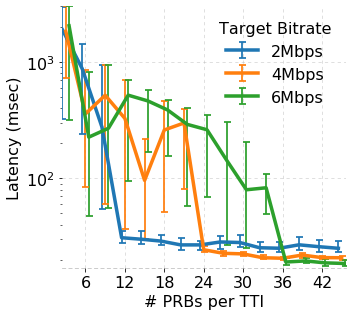

In [6]:
CAPSIZE = LINE_WIDTH
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

ax1.set_xlabel('# PRBs per TTI', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency (msec)', fontsize=FONT_SIZE)

offset = -0.5
offset_step = 0.5
for target_rate, data in ue_data.items():
    plt.errorbar(np.unique(data[active_slice]['raw_n_rbgs']) * N_PRB_PER_RBG + offset, 
                 data[active_slice]['filtered_rtt_msec'], 
                 yerr=data[active_slice]['filtered_rtt_margin_msec'], 
                 label=target_rate+'bps', capsize=CAPSIZE, capthick=CAPSIZE/2, 
                 elinewidth=LINE_WIDTH/2, linewidth=LINE_WIDTH)
    offset += offset_step

ax1.tick_params(axis='y', labelsize=FONT_SIZE)
ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.set_ylim((17, 3000))
ax1.xaxis.set_ticks(np.arange(0, 16 * N_PRB_PER_RBG, 6))
ax1.set_xlim([2.4, 45.6])

ax1.legend(title='Target Bitrate', loc='upper right', frameon=False, 
           title_fontsize=FONT_SIZE, fontsize=FONT_SIZE, markerscale=2,)
ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)
ax1.set_yscale('log')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'lat_vs_prbs_for_different_thp.pdf')

plt.show()

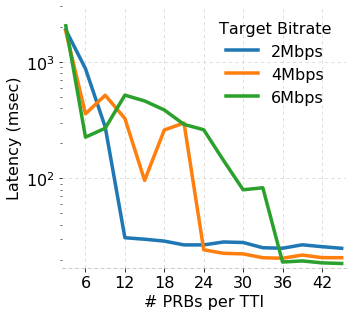

In [7]:
CAPSIZE = LINE_WIDTH
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

ax1.set_xlabel('# PRBs per TTI', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency (msec)', fontsize=FONT_SIZE)

for target_rate, data in ue_data.items():
    plt.plot(np.unique(data[active_slice]['raw_n_rbgs']) * N_PRB_PER_RBG, 
                 data[active_slice]['filtered_rtt_msec'],
                 label=target_rate+'bps', linewidth=LINE_WIDTH)

ax1.tick_params(axis='y', labelsize=FONT_SIZE)
ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.set_ylim((17, 3000))
ax1.xaxis.set_ticks(np.arange(0, 16 * N_PRB_PER_RBG, 6))
ax1.set_xlim([2.4, 45.6])

ax1.legend(title='Target Bitrate', loc='upper right', frameon=False, 
           title_fontsize=FONT_SIZE, fontsize=FONT_SIZE, markerscale=2,)
ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)
ax1.set_yscale('log')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'ave_lat_vs_prbs_for_different_thp.pdf')

plt.show()